In [2]:
import numpy as np
import math
import time

from scipy import linalg as la
from scipy import sparse
from scipy.special import erfc
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import transforms
from matplotlib import rc
from matplotlib import cm
from IPython.display import HTML

---
Graphic tools

In [3]:
def simple_plotter(ks, title='Simple plot'):
    """
    Graphic tool to plot simple values
    """
    fig, ax = plt.subplots()
    fig.tight_layout()
    plt.title(title)
    for k in ks:
        ax.plot(range(len(k)), k)
    
    plt.show()

In [4]:
def matrix_plotter(M):
    """
    Graphic tool to plot the matrix M
    """
    fig, ax = plt.subplots(dpi=150)
    ax.spy(M)
    
    if (type(M) is not coo_matrix):
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                if (M[i][j]): 
                    color = 'w' if M[i][j] != -2 else 'k'
                    ax.text(i, j, str(int(M[i][j])), va='center', ha='center', color=color)
    
    plt.show()

In [5]:
def domain_curve(k, v, L):
    """
    Graphic tool to plot eigenvector v in 1-dimension domain.
    :param k: eigenvalue associated to the eigenvector
    :param v: eigenvector
    :param L: number of row
    :param title: plot title
    """
    fig, ax = plt.subplots()
    fig.tight_layout()
    frequency = np.sqrt(abs(np.real(k)))
    plt.title(r'Eigenmode for $\lambda$={:2f}'.format(frequency))
    ax.plot(v, 'bo')
    plt.show()

---
### Analytic solution

$u(x,t) = \sum^{\inf}_{n=1} c_n e^{-\pi^2 n^2 t} sin(n \pi x)$

In [6]:
def analytical_heat_1d(t, x, n_max: int=100):
    return np.sum([np.exp(-np.pi**2 * n**2 * t) * np.sin(n * np.pi * x) for n in range(n_max)], axis=0)

def get_heat(t_max, x_max, dt, dx):
    t_axis = np.linspace(0, t_max, int(t_max/dt))
    x_axis = np.linspace(0, x_max, int(x_max/dx))
    
    return analytical_heat_1d(t_axis[:, None], x_axis[None, :], 10)

(10, 100)


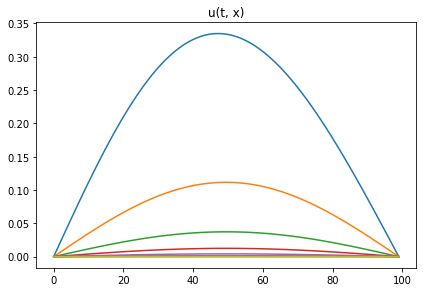

In [7]:
u = get_heat(1, 1, 0.1, 0.01) # 0.0001, 0.5, 0.00001, 0.01)
print(u.shape)
simple_plotter(u[1:], 'u(t, x)')

---
### Finite element solution

Try a finite element solution implementation

In [8]:
def get_B(X):
    # Mass matrix (Gram). Basis matrix. Positive definite, inversible
    b = np.zeros((X, X))
    d = 1 / (X - 1)
    
    for i in range(X):
        b[i][i] = 4
    
    for i in range(X-1):
        b[i][i+1] = 1
        b[i+1][i] = 1
    
    B = b * d / 6
    
    return B

In [9]:
def get_A(X):
    # Stiffness matrix (Gram).
    a = np.zeros((X, X))
    d = 1 / (X - 1)
    for i in range(X):
        a[i][i] = 2
        
    for i in range(X-1):
        a[i][i+1] = -1
        a[i+1][i] = -1
        
    A = a * (1. / d)
    
    return A

In [10]:
def get_F(X, T):
    d = 1 / (X - 1)
    F = np.zeros((X, T))
    
    t = np.linspace(0, 1, T)
    x = np.linspace(0, 1, X)

    for k in range(T):
        for i in range(1, X):
            F[i][k] = gauss_quadrature(x[i], d, t[k])
            
    return F

In [11]:
def f(x, t):
    # No source function
    return ((np.pi**2) - 1) * np.exp(-t) * np.sin(np.pi * x)

In [12]:
def gauss_quadrature(x, h, t):
    a = x - h/2
    b = x + h/2
    x1 = -np.sqrt(1. / 3.)
    x2 = np.sqrt(1. / 3.)
    
    a1 = ((b - a) * x1 + a + b) / 2
    a2 = ((b - a) * x2 + a + b) / 2
    return (f(a1, t) + f(a2, t)) * (b - a) / 2

In [13]:
def finite_element_heat_1d(t, x, dt, dx):
    T = int(t // dt)
    X = int(x // dx)
    B = get_B(X)  # mass
    A = get_A(X)  # stiffness
    F = get_F(X, T)
    
    c = np.zeros((X, T))
    c0 = get_heat(1, x, 1, dx).T
    c[:,0] = c0[1:, 0]
    
    for t in range(0, T-1):
        tmp1 = 0 # dt * F[:,t]
        tmp2 = - dt * np.matmul(A, c[:,t])
        c[:, t+1] = np.linalg.solve(B, tmp1 + tmp2) + c[:,t]
    
    return c.T

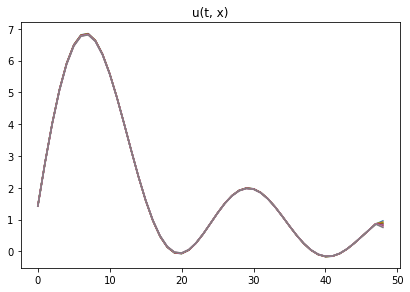

In [14]:
u_fe2 = finite_element_heat_1d(0.0001, 0.5, 0.00001, 0.01)
simple_plotter(u_fe2[1:], 'u(t, x)')

----
### Finite difference discrete solution

Using Dirichlet conditions at 0

In [15]:
def finite_difference_heat_1d(t, x, dt, dx):
    T = int(t // dt)
    X = int(x // dx)
    u0 = get_heat(1, x, 1, dx)
    u = np.zeros((T + 1, X + 1))
    u[0][:] = u0
    
    for i in range(1, T):
        for k in range(2, X):
            u[i][k] = (u[i-1][k-1] - 2 * u[i-1][k] + u[i-1][k+1]) * dt / (dx**2) + u[i-1][k]
    
    return u

(10, 50)


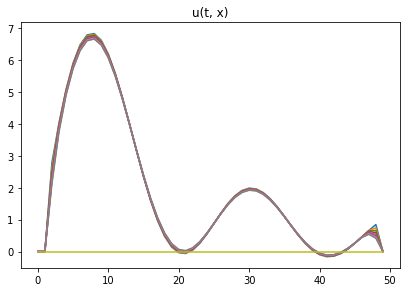

In [16]:
u_fd = finite_difference_heat_1d(0.0001, 0.5, 0.00001, 0.01)
print(u_fd.shape)
simple_plotter(u_fd[1:], 'u(t, x)')

---
### Proper orthogonal decomposition (POD)


In [17]:
def pod_beta(t, x, dt, dx, k_min=0, k_max=1):
    T = int(t // dt)
    X = int(x // dx)
    # Compute snapshot
    U = get_heat(t-dt, x-dx, dt, dx)
    # U = finite_element_heat_1d(t, x, dt, dx)
    # U = S - np.mean(S, axis=0) # Remove temporal mean
    
    # Get covariance matrix
    C = np.matmul(U.T, U) # / X
    
    # Solve eigenproblem
    K, v = la.eigh(C, b=None)
    
    # Sort eigen values and vectors
    indexes = np.argsort(-abs(K))
    K = K[indexes] # eigenvalue
    v = v[:, indexes] # eigenvector = spatial mode
    
    # Compute time coefficient
    A = np.matmul(U, v.T);
    
    u_tilde = np.zeros((T, X))
    
    for k in range(k_min, k_max, 1):
        Vk = v[k, :]
        Vk = Vk[np.newaxis, :]
        Ak = A[:, k] 
        Ak = Ak[:, np.newaxis]
        u_tilde_k = np.matmul(Ak, Vk)
        # M finite-element mass matrix
        # Compute SVD of snapshot matrix
        u_tilde += u_tilde_k
    
        # simple_plotter(u_tilde_k, r'$\hat{u}_k(t, x)$')
    simple_plotter(u_tilde, r'$\hat{u}(t, x)$')


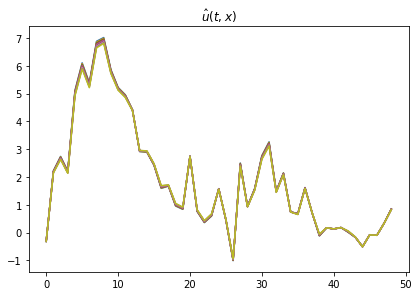

In [28]:
# Obtenir la matrice des snapshots
T = 0.0001
X = 0.5
dt = 0.00001
dx = 0.01

pod_beta(T, X, dt, dx, 0, 35)

In [19]:
def pod(t, x, dt, dx, k_max=1, theta=1):
    T = int(t // dt)
    X = int(x // dx)
    
    u0 = finite_element_heat_1d(t, x, dt, dx)
    M = get_B(X)
    A = get_A(X)
    F = get_F(X, T)
    B1 = np.dot(M, u0.T)
    B2 = np.transpose(B1)
    Bapp = dt * np.dot(B1, B2)
    K, v = la.eigh(Bapp, M)
    
    En = np.zeros((X, k_max)) 
    for k in range(0, k_max):
        En[:, k] = v[:, X-k-1]
    
    Sn = np.dot(En.T,np.dot(M, En))
    Kn = np.dot(np.dot(En.T, A),En)
    Fbarn = np.dot(En.T, F)
    
    Dtab = np.zeros((k_max, T+1))
    Dold = np.zeros(k_max)
    Dtab[:,0] = Dold
    
    for p in range(0, T):
        B = np.dot((Sn - (1 - theta)*dt*Kn), Dold)
        A = Sn+theta*dt*Kn
        Dnew = la.solve(A, B) 
        Dtab[:,p+1] = Dnew 
        Dold = Dnew
        Utab = np.dot(En, Dtab)
        
    return Utab
    
#     K, s, Vh = la.svd(U)
#     phi = Vh
#     A = np.matmul(U, phi)

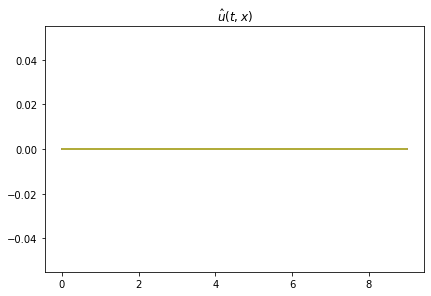

In [20]:
# Obtenir la matrice des snapshots
T = 0.0001
X = 0.5
dt = 0.00001
dx = 0.01

u2 = pod(T, X, dt, dx)
simple_plotter(u2, r'$\hat{u}(t, x)$')

---
### Eigenvalue problem

In [147]:
def generate_eigenproblem(L):
    # Set value of K with consideration of border
    def set_value(K, i, j, val):
        if (i >= 0 and i < K.shape[0] and j >= 0 and j < K.shape[1]):
            K[i, j] = val
    
    K = np.zeros((L, L), np.float64)
    np.fill_diagonal(K, -2)
    set_value(K, 0, 1, 1)
    set_value(K, L-1, L-2, 1)
    
    for i in range(1, L-1):
        set_value(K, i, i - 1, 1)
        set_value(K, i, i + 1, 1)
    
    return K

In [131]:
def solve_eigenproblem(L, h):
    """
    Solve eigenproblem using a dense matrix
    :param N: domain size
    :param L: domain side length
    :param shape: membrane shape. 0 = square, 1 = rectangle, 2 = circle
    """
    M = generate_eigenproblem(L)
    start = time.time()
    w, v = la.eigh(M, b=None)
    K = w / (h**2)
    return K, v

(100,)
(100, 100)


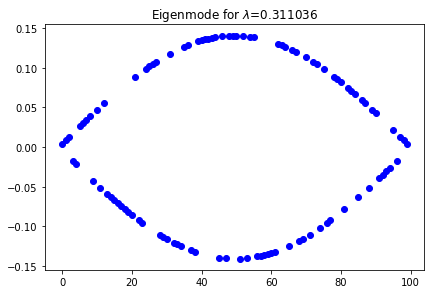

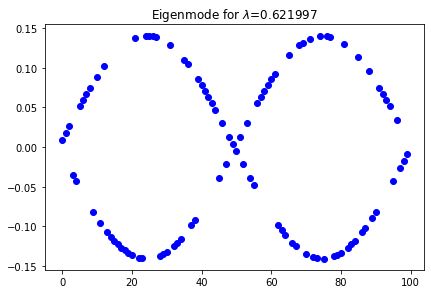

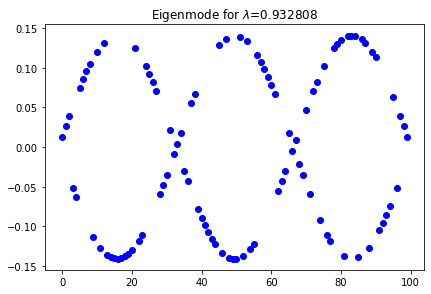

In [426]:
# M = generate_eigenproblem(10, 0.1)
# matrix_plotter(M)
L = 100
h = 0.1
K, v = solve_eigenproblem(L, h)
print(K.shape)
print(v.shape)
indexes = np.argsort(abs(K))
K = K[indexes]
v = v[:, indexes]

domain_curve(K[0], v[0,:], L)
domain_curve(K[1], v[1,:], L)
domain_curve(K[2], v[2,:], L)